In [1]:
from ml_utils import *

In [10]:
dtf = pd.read_csv('http://bit.ly/kaggletrain')
dtf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


len dtf: 891
PassengerId --> Nas: 0 (0.0%)
    # possible pk
Survived --> Nas: 0 (0.0%)
Pclass --> Nas: 0 (0.0%)
Name --> Nas: 0 (0.0%)
    # possible pk
Sex --> Nas: 0 (0.0%)
Age --> Nas: 177 (19.900000000000002%)
SibSp --> Nas: 0 (0.0%)
Parch --> Nas: 0 (0.0%)
Ticket --> Nas: 0 (0.0%)
Fare --> Nas: 0 (0.0%)
Cabin --> Nas: 687 (77.10000000000001%)
Embarked --> Nas: 2 (0.2%)


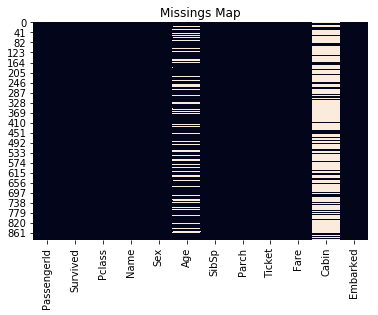

In [11]:
check_Nas(dtf, plot="map")

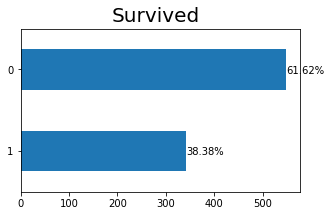

In [12]:
freqdist_plot(dtf, "Survived", figsize=(5,3))

###### rr
- pk: PassengerId, Name
- y: Survived
- who: Sex, Age
- wealth: Pclass, Ticket, Fare
- where: Parch, Cabin, Embarked
- how many: SibSp 

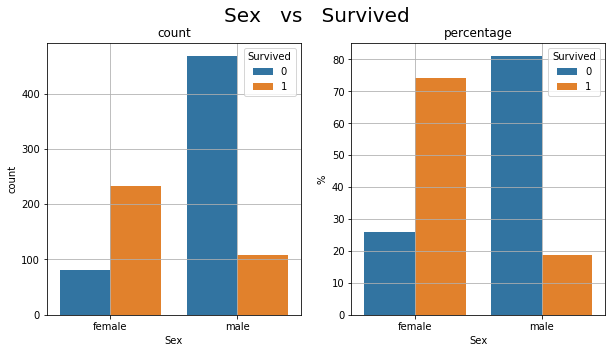

In [13]:
bivariate_plot(dtf, x="Sex", y="Survived", figsize=(10,5))

In [14]:
dtf["Age"].mean()

29.69911764705882

In [15]:
dtf["Age"] = dtf["Age"].fillna( dtf["Age"].mean() )

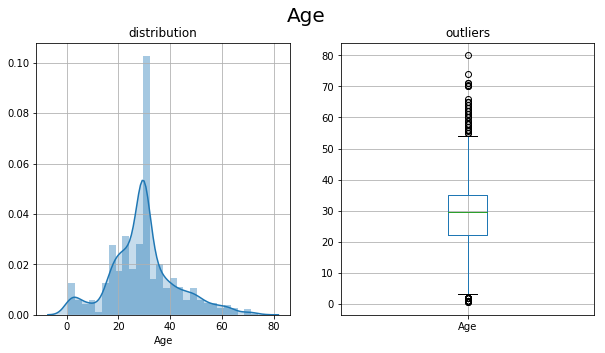

In [17]:
freqdist_plot(dtf, "Age", figsize=(10,5))

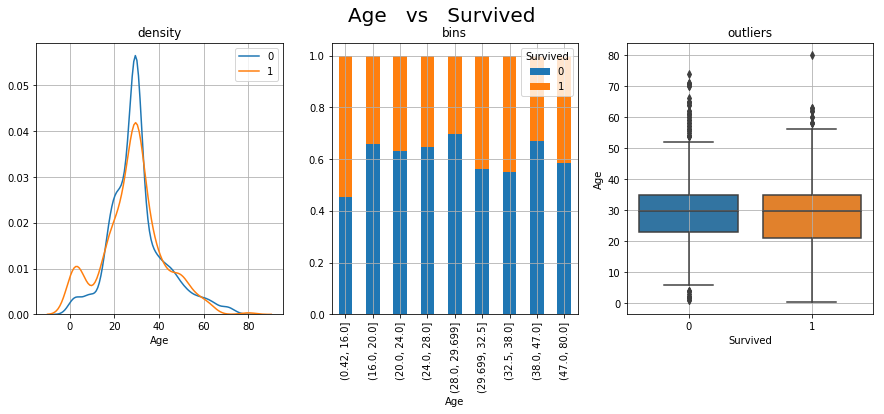

In [19]:
bivariate_plot(dtf, x="Age", y="Survived", figsize=(15,5))

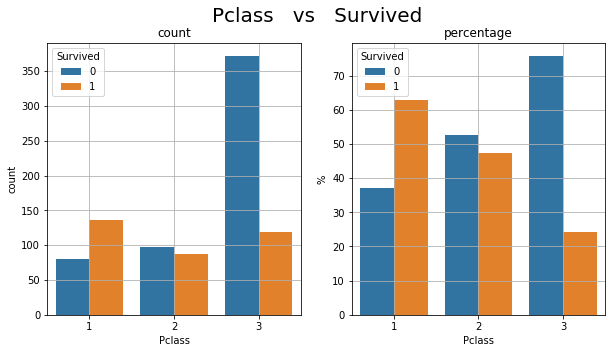

In [20]:
bivariate_plot(dtf, x="Pclass", y="Survived", figsize=(10,5))

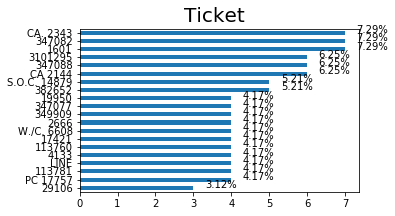

In [21]:
freqdist_plot(dtf, "Ticket", figsize=(5,3))

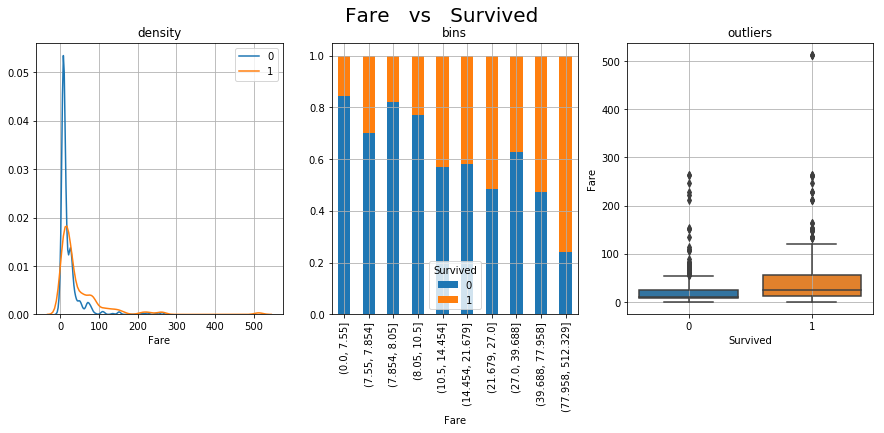

In [22]:
bivariate_plot(dtf, x="Fare", y="Survived", figsize=(15,5))

In [ ]:
bivariate_plot(dtf, x="Fare", y="Survived", figsize=(15,5))